In [22]:
# Import helper libraries
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import
from future import standard_library
standard_library.install_aliases()  # NOQA
import argparse
import logging
import sys

#___________________________________________________________________
# Import scientific libraries

import numpy as np               # Numpy, a good library to deal with matrices in python.
import matplotlib.pyplot as plt  # Matplotlib, a good library for plotting in python.
from matplotlib import style
#___________________________________________________________________

import gym                       # Gym, a collection of RL environemnts.
gym.undo_logger_setup()  # NOQA
from gym import spaces
import gym.wrappers

from osim.env import ProstheticsEnv   # Open simulator (OSIM), an open source simnulation for biomechanical modeling.

#___________________________________________________________________



import tensorflow as tf                      # Tensorflow, a deep learning library.
import chainer                               # Chainer, a python-based deep learning framework. Chainerrl, a reinforcement learning library based on chainer framework.
from chainer import optimizers               # a collection of Neural Network optimizers.
from chainerrl.agents.ddpg import DDPG       # a DDPG agent
from chainerrl.agents.ddpg import DDPGModel  # a DDPG model, responsibles to combine the policy network and the value function network.
from chainerrl import explorers              # a collection of explores functions.
from chainerrl import misc                   # a collection of utility functions to manipulate the environemnts.
from chainerrl import policy                 # a policy network
from chainerrl import q_functions            # a value function network
from chainerrl import replay_buffer          # a Replay buffer to store a set of observations for the DDPG agent.


from ExpertAgents import ExpertDDPGAgent
style.use('ggplot')

/home/waleed_daud_wd/CondaEnvs/opensimEnv_V2/lib/python3.6/site-packages/gym/__init__.py:15: UserWarning: gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration
  warnings.warn("gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration")


# A set of helper functions 

In [23]:
# Helper's functions

def clip_action_filter(a):
    """ limit the an action value between the higest and lowest values in action space.
    Input: a
    Output: clipped action
    """
    return np.clip(a, action_space.low, action_space.high)

def reward_filter(r):
    """ Scale the reward value.
    Input: reward (r)
    Output: scaled reward
    """
    return r *1 #1e-2


def phi(obs):
    """ Convert the data type of the observation to float-32
    Input: observation (obs)
    Output:  the processed observation 
    """ 
    obs=np.array(obs)
    return obs.astype(np.float32)


def random_action():
    """ Generate a random action.
    Input: None
    Output:  a random action
    """ 
    a = action_space.sample()
    if isinstance(a, np.ndarray):
        a = a.astype(np.float32)
    return a


def make_env(test,render=False):
    
    """ Create an instance from "ProstheticEnv" environment
    Input: a boolean value to show if it's an agent training experiment or test experiment (test)
    Output:  "ProstheticEnv" environment (env)
    """ 
        
    env = ProstheticsEnv(visualize=render)
    # Use different random seeds for train and test envs
    env_seed = 2 ** 32 - 1 - seed if test else seed
    env.seed(env_seed)
    #if args.monitor:
        #env = gym.wrappers.Monitor(env, args.outdir)
    if isinstance(env.action_space, spaces.Box):
        misc.env_modifiers.make_action_filtered(env, clip_action_filter)
    if not test:
        misc.env_modifiers.make_reward_filtered(env, reward_filter)
    if render and not test:
        misc.env_modifiers.make_rendered(env)
    return env

In [24]:
seed=0

# Set up the environment.

In [25]:
# Setup the environment
env = make_env(test=False,render=False)
#timestep_limit = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
obs_size = np.asarray(env.observation_space.shape).prod()
action_space = env.action_space
action_size = np.asarray(action_space.shape).prod()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Could not seed environment <ProstheticsEnv<0>>


In [26]:
load_expert_DDPG=ExpertDDPGAgent(path="Models/Model")
expert=load_expert_DDPG.load_agent()

In [27]:
number_of_episodes=50
max_episode_length=1000

In [28]:
# STEP 1: Generate Data using Expert.

returns = []
observations = []
actions = []
for i in range(number_of_episodes):
    print('episode: ', i)
    obs = env.reset()
    done = False
    G = 0.
    steps = 0
    while not done:
        action = expert.act(obs)
        
        observations.append(obs)
        actions.append(action)
        
        obs, r, done, _ = env.step(action)
        G += r
        steps += 1
        
        if steps % 100 == 0: print("%i/%i" % (steps, max_episode_length))
        if steps >= max_episode_length:
            break
    returns.append(G)
    
print('returns', returns)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

episode:  0
episode:  1
episode:  2
episode:  3
episode:  4
episode:  5
episode:  6
episode:  7
episode:  8
episode:  9
episode:  10
episode:  11
episode:  12
episode:  13
episode:  14
episode:  15
episode:  16
episode:  17
episode:  18
episode:  19
episode:  20
episode:  21
episode:  22
episode:  23
episode:  24
episode:  25
episode:  26
episode:  27
episode:  28
episode:  29
episode:  30
episode:  31
episode:  32
episode:  33
episode:  34
episode:  35
episode:  36
episode:  37
episode:  38
episode:  39
episode:  40
episode:  41
episode:  42
episode:  43
episode:  44
episode:  45
episode:  46
episode:  47
episode:  48
episode:  49
returns [58.46354079844838, 61.209274357659105, 59.327096861418624, 59.659493652465414, 60.409880098946, 59.370351321407675, 60.43158585851299, 61.19207583830714, 60.60999319150469, 60.124528563961235, 59.611840840975375, 58.98068901640656, 59.57588400054966, 63.84890689365919, 62.17163118973635, 59.14807169186517, 63.346016184291386, 62.73403969843032, 61.8

In [29]:
# pass observations, actions to imitation learning
obs_data = np.squeeze(np.array(observations))
act_data = np.squeeze(np.array(actions))

In [30]:
# Save the observations and actions of the expert policy
np.savetxt('Datasets/obs_data_naive_agent-immediate_reward.txt', obs_data, fmt='%f')
np.savetxt('Datasets/act_data_naive_agent-immediate_reward.txt', obs_data, fmt='%f')

# Build the policy network for the target agent.

In [31]:
#===========================================================================
# Build the policy network for the Target agent.
#===========================================================================

In [32]:
obs_dim = obs_data.shape[1]
act_dim = act_data.shape[1]

In [33]:
# Architecture of the target policy function

x = tf.placeholder(tf.float32, shape=[None, obs_dim])
yhot = tf.placeholder(tf.float32, shape=[None, act_dim])
    
h1 = tf.layers.dense(inputs=x, units=128, activation=tf.nn.relu)
h2 = tf.layers.dense(inputs=h1, units=64, activation=tf.nn.relu)
h3 = tf.layers.dense(inputs=h2, units=32, activation=tf.nn.relu)
yhat = tf.layers.dense(inputs=h3, units=act_dim, activation=None)
yhat= tf.squeeze(yhat)
    
loss = tf.reduce_mean(tf.square(yhot - yhat))
train = tf.train.AdamOptimizer().minimize(loss)

# Saver object to save the model
saver = tf.train.Saver()

In [34]:
# train The target network
number_of_iterations=100
batch_size = 25

# Metrices

global_mean_G=[]

In [ ]:
#___________ STEP 2: Train the target agent with the data that collected by the expert agent. ____________

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # record return and std for plotting
    save_mean = []
    save_std = []
    save_train_size = []
    #loop for dagger alg
    
    for dagger_iter in range(number_of_iterations):
        print ('DAgger iteration ', dagger_iter)
        
        # train a policy by fitting the MLP
        for step in range(10000):
            batch_i = np.random.randint(0, obs_data.shape[0], size=batch_size)
            train.run(feed_dict={x: obs_data[batch_i, ], yhot: act_data[batch_i, ]})
            if (step % 1000 == 0):
                print ('opmization step ', step)
                print ('obj value is ', loss.eval(feed_dict={x:obs_data, yhot:act_data}) )        
                
        print('Optimization Finished!')
        
        # save naive agent
        saver.save(sess, 'NaiveAgents/Model_V1/naive_agent-immediate_reward',global_step=1000,write_meta_graph=False)



#______________________ STEP 3: Generate data using target Agent. ________________________
        
        
        returns = []
        naive_rewards=[]
        naive_observations = []
        naive_actions = []
        for i in range(number_of_episodes):
            print('iter', i)
            obs = env.reset()
            done = False
            G = 0.
            steps = 0
            while not done:
                obs=np.array(obs)
                action = yhat.eval(feed_dict={x:obs[None, :]})
                naive_observations.append(obs)
                naive_actions.append(action)
                
                obs, r, done, _ = env.step(action)
                naive_rewards.append(r)
                G += r
                steps += 1   
                if steps % 100 == 0: print("%i/%i" % (steps, max_episode_length))
                if steps >= max_episode_length:
                    break
            returns.append(G)
            
        global_mean_G.append(np.mean(returns))
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))
            
            
#_________________________ STEP 4: Expert labeling ____________________________________
 
        corrected_act = []
        expert_rewards=[]
        expert_actions=[]
        
        for i in range(len(naive_observations)):
            expert_action=expert.act(naive_observations[i])
            _,expert_reward,_,_=env.step(expert_action)
            expert_actions.append(expert_action)
            expert_rewards.append(r)

        for i in range(len(naive_observations)):
            # Compare the expert's immediate reward with target's immediate reward in each given state.
            if expert_rewards[i] >= naive_rewards[i]:         # if expert's immediate reward is bigger, use expert action.            
                corrected_act.append(expert_actions[i])
            elif expert_rewards[i] < naive_rewards[i] :       # else use target action
                corrected_act.append(naive_actions[i])
                
            
        # record training size
        train_size = obs_data.shape[0]
        
#_________________________ STEP 5: data aggregation _____________________________________
        
        obs_data = np.concatenate((obs_data, np.array(naive_observations)), axis=0)
        act_data = np.concatenate((act_data, np.squeeze(np.array(corrected_act))), axis=0)
        
        
        
        # record mean return & std
        save_mean = np.append(save_mean, np.mean(returns))
        save_std = np.append(save_std, np.std(returns))
        save_train_size = np.append(save_train_size, train_size)
        
    dagger_results = {'means': save_mean, 'stds': save_std, 'train_size': save_train_size,}
    
    print ('DAgger iterations finished!')  

DAgger iteration  0
opmization step  0
obj value is  510765.9
opmization step  1000
obj value is  0.32800734
opmization step  2000
obj value is  0.25026545
opmization step  3000
obj value is  0.18757014
opmization step  4000
obj value is  0.16048968
opmization step  5000
obj value is  0.1449579
opmization step  6000
obj value is  0.13669564
opmization step  7000
obj value is  0.12620889
opmization step  8000
obj value is  0.11883771
opmization step  9000
obj value is  0.114693426
Optimization Finished!
iter 0
100/1000
iter 1
100/1000
iter 2
100/1000
iter 3
100/1000
iter 4
100/1000
iter 5
100/1000
iter 6
100/1000
iter 7
100/1000
iter 8
100/1000
iter 9
100/1000
iter 10
100/1000
iter 11
100/1000
iter 12
100/1000
iter 13
100/1000
iter 14
100/1000
iter 15
100/1000
iter 16
100/1000
iter 17
100/1000
iter 18
100/1000
iter 19
100/1000
iter 20
100/1000
iter 21
100/1000
iter 22
100/1000
iter 23
100/1000
iter 24
100/1000
iter 25
100/1000
iter 26
100/1000
iter 27
100/1000
iter 28
100/1000
iter 29
1

In [38]:
# Save the Mean of the Returns.
global_mean_G=np.array(global_mean_G) 
np.savetxt('Variables/global_mean_G.txt', global_mean_G , fmt='%f')

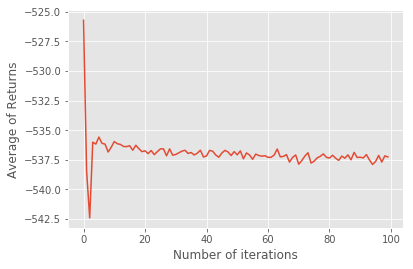

In [39]:
plt.plot(global_mean_G)
plt.ylabel('Average of Returns')
plt.xlabel('Number of iterations')
plt.savefig("Plots/Average_of_Returns_iterations_immediate_reward.png")

In [ ]:
print(global_mean_G)